# Complexity of Matrix Operations

With a little effort, we can figure out that the **number of arithmetic operations** for an $n\times n$ matrix **scales proportional to** (for large $n$):

* $n^2$ for: matrix `*` vector $Ax$, or solving a *triangular* system like $Ux=c$ or $Lc=b$ (back/forward substitution)
* $n^3$ for: matrix `*` matrix $AB$, LU factorization $PA=LU$, or solving a triangular system with $n$ right-hand sides like computing $A^{-1}$ from the LU factorization.

(In computer science, we would say that these have "complexity" $\Theta(n^2)$ and $\Theta(n^3)$, respectively.

Let's see how these predictions match up to reality:

In [16]:
Pkg.add("BenchmarkTools") # a useful package for benchmarking
using BenchmarkTools, Compat

INFO: Package BenchmarkTools is already installed
INFO: METADATA is out-of-date — you may not have the latest version of BenchmarkTools
INFO: Use `Pkg.update()` to get the latest versions of your packages


Measure the time for LU factorization of 10×10, 100×100, 500×500, 1000×1000, and 2000×2000 random real (double precision) matrices:

In [17]:
n = [10,100,500,1000,2000]
LinAlg.BLAS.set_num_threads(1) # benchmarking on multiple cores is weird
t = [@belapsed(lufact($(rand(n,n))), evals=1) for n in n]

5-element Array{Float64,1}:
 1.149e-6   
 0.000160689
 0.00394636 
 0.0257531  
 0.175274   

Now let's plot it on a log–log scale to see if it is the expected $n^3$ power law:

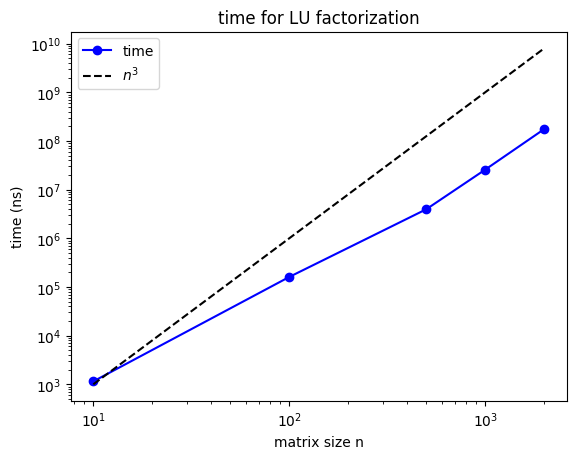

PyObject <matplotlib.text.Text object at 0x13f99f810>

In [18]:
using PyPlot
loglog(n, t*1e9, "bo-")
loglog(n, n.^3, "k--")
xlabel("matrix size n")
ylabel("time (ns)")
legend(["time", L"n^3"])
title("time for LU factorization")

It's pretty close!  For large $n$, you can see it starting to go parallel to the $n^3$ line.

The reason it is initially *better* than $n^3$ (i.e. it is faster than the $n^3$ dependence would suggest) is that there is apparently some overhead in setting up the matrix multiplication that adds a significant fraction of the time for small matrices, but is negligible for large matrices.

Let's also look at the time to *solve* $LUx=b$ when we are *given* the LU factors, which we predict should grow $\sim n^2$:

In [19]:
ts = [@belapsed($(lufact(rand(n,n))) \ $(rand(n))) for n in n]

5-element Array{Float64,1}:
 3.10107e-7 
 0.000157249
 0.000938176
 0.00192759 
 0.00616312 

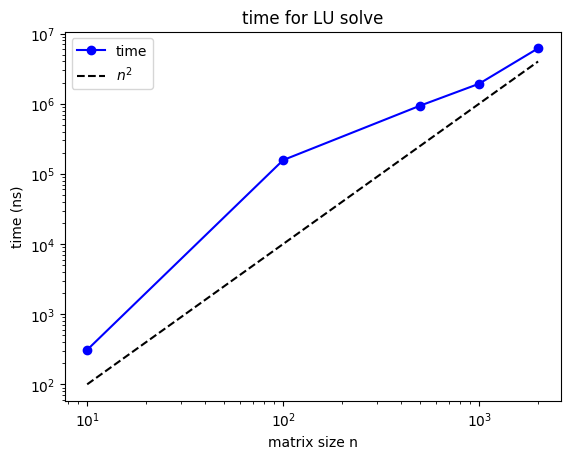

PyObject <matplotlib.text.Text object at 0x12a72de10>

In [20]:
loglog(n, ts*1e9, "bo-")
loglog(n, n.^2, "k--")
xlabel("matrix size n")
ylabel("time (ns)")
legend(["time", L"n^2"])
title("time for LU solve")

Yup, it's pretty close to the $n^2$ growth!  The key point is that, unless you have many ($\gtrsim n$) right-hand sides, most of the effort is spent in Gaussian elimination (finding L and U), *not* in the back/forward-substitution to solve $LUx=b$.

If we believe this scaling, how long would it take for my laptop to solve a $10^6 \times 10^6$ system of equations?

In [32]:
Dates.canonicalize(Dates.CompoundPeriod(Dates.Second(round(Int,t[end] * (1e6/2000)^3))))

36 weeks, 1 day, 13 hours, 54 minutes, 7 seconds

In fact, we **usually run out of memory before we run out of time:**

In [22]:
println((1e6)^2 * sizeof(Float64) / 2^30, " GiB for a 10⁶×10⁶ matrix")

7450.580596923828 GiB for a 10⁶×10⁶ matrix


In practice, people do *regularly* solve problems this large, and even larger, but they can do so because real matrices that big almost always have some **special structure** that allows you to solve them more quickly and store them more compactly.  For example, a common special structure is [sparsity](https://en.wikipedia.org/wiki/Sparse_matrix): matrices whose entries are *mostly zero*.  We will learn some basic ways to take advantage of this later in 18.06, and sparse-matrix methods are covered more extensively in 18.335.

# Transpose, Permutations, and Orthogonality

One special type of matrix for which we can solve problems much more quickly is a permutation matrix, introduced in the previous lecture on $PA=LU$ factorization.

In [23]:
# construct a permutation matrix P from the permutation vector p
function permutation_matrix(p)
    P = zeros(Int, length(p),length(p))
    for i = 1:length(p)
        P[i,p[i]] = 1
    end
    return P
end

permutation_matrix (generic function with 1 method)

In [24]:
P = permutation_matrix([2,4,1,5,3])

5×5 Array{Int64,2}:
 0  1  0  0  0
 0  0  0  1  0
 1  0  0  0  0
 0  0  0  0  1
 0  0  1  0  0

In [25]:
P * I₅

5×5 Array{Int64,2}:
 0  1  0  0  0
 0  0  0  1  0
 1  0  0  0  0
 0  0  0  0  1
 0  0  1  0  0

The inverse of any permutation matrix $P$ turns out to be its [transpose](https://en.wikipedia.org/wiki/Transpose) $P^T$: we just swap rows and columns.  In Julia, this is denoted `P'` (technically, this is the conjugate transpose, and `P.'` is the transpose, but the two are the same for real-number matrices where complex conjugation does nothing).

In [26]:
P'

5×5 Array{Int64,2}:
 0  0  1  0  0
 1  0  0  0  0
 0  0  0  0  1
 0  1  0  0  0
 0  0  0  1  0

In [27]:
P'*P

5×5 Array{Int64,2}:
 1  0  0  0  0
 0  1  0  0  0
 0  0  1  0  0
 0  0  0  1  0
 0  0  0  0  1

In [28]:
P*P'

5×5 Array{Int64,2}:
 1  0  0  0  0
 0  1  0  0  0
 0  0  1  0  0
 0  0  0  1  0
 0  0  0  0  1

The reason this works is that $P^T P$ computes the dot products of *all the columns* of $P$ with *all of the columns*, and the columns of $P$ are [orthonormal](https://en.wikipedia.org/wiki/Orthonormality) (orthogonal with length 1).  We say that $P$ is an example of an ["orthogonal" matrix or a "unitary" matrix](https://en.wikipedia.org/wiki/Unitary_matrix).  We will have much to say about such matrices later in 18.06.

## Transposes and products

Transposes are important in linear algebra because they have a special relationship to matrix and vector products:
$$
(AB)^T = B^T A^T
$$
and hence for a dot product (inner product) $x^T y$
$$
x \mbox{ dot } (Ay) = x^T (Ay) = (A^T x)^T y = (A^T x) \mbox{ dot } y
$$
We can even turn the second step around and use this as the *definition* of a transpose: a transpose is *what "moves" a matrix from one side to the other of a dot product.*

In [29]:
C = rand(-9:9, 4,4)
D = rand(-9:9, 4,4)
(C*D)' == D'*C'

true

## Transposes and inverses

From the above property, we have:
$$
(A A^{-1})^T = (A^{-1})^T A^T = I^T = I
$$
and it follows that:
$$
(A^{-1})^T = (A^T)^{-1}
$$
The *transpose of the inverse* is the *inverse of the transpose*.

In [30]:
inv(A')

5×5 Array{Float64,2}:
  0.0109991   0.131989  -0.235564  -0.301558    0.2044   
  0.529789    0.35747   -0.179652  -0.69172     0.678582 
 -0.908341   -0.900092   0.370302   1.48701    -1.29667  
 -0.635197   -0.622365   0.353804   1.16499    -1.05408  
 -0.0879927  -0.055912  -0.11549    0.0791323   0.0314696

In [31]:
inv(A)'

5×5 Array{Float64,2}:
  0.0109991   0.131989  -0.235564  -0.301558    0.2044   
  0.529789    0.35747   -0.179652  -0.69172     0.678582 
 -0.908341   -0.900092   0.370302   1.48701    -1.29667  
 -0.635197   -0.622365   0.353804   1.16499    -1.05408  
 -0.0879927  -0.055912  -0.11549    0.0791323   0.0314696

As expected, they match!

# Transposes and LU factors

If $A = LU$, then $A^T = U^T L^T$.  Note that $U^T$ is *lower* triangular, and $L^T$ is *upper* trangular.  That means, that once we have the LU factorization of $A$, we immediately have a similar factorization of $A^T$.